利用logistic回归对乳腺癌数据集进行分类

1导入类库

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
#计算各性能指标的方法
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


Logistic回归类

In [3]:
class LogisticRegression(object):

    def __init__(self,Train_Data,Train_Label,theta=None):
        """
        初始化函数
        :param Train_Data:训练数据集，类型为numpy.ndarray
        :param Train_Label:训练标签集，类型为numpy.ndarray
        :param theta:回归参数，类型为numpy.ndarray,默认为None
        """
        self.Train_Data = []
        self.Train_Label = Train_Label
        #print("init中的traindata:\n",Train_Data.shape)
        #给每组输入数据增添常数项1
        for train_data in Train_Data:
            data = [1.0]
            data.extend(list(train_data))
            #print("init中的data：\n",data)
            self.Train_Data.append(data)
        self.Train_Data = np.array(self.Train_Data)
        #参数theta不为None时，利用theta构造模型参数
        if theta is not None:
            self.Theta = theta
        else:
            size = np.shape(self.Train_Data)
            self.Theta = np.random.randn(size)
    
    def Sigmoid(self,x):
        """
        计算sigmoid函数值
        :param x:输入数据
        """
        return 1.0 / (1.0 + np.exp(-x))

    def Shuffle_Sequence(self):
        """
        这是在运行SGD算法或MBGD算法之前，随机打算或原始数据集的函数
        """
        #首先获得训练集规模，然后按照规模生成自然数序列
        length = len(self.Train_Label)
        random_sequence = list(range(length))
        #利用numpy的随机打乱函数训练数据下标
        random_sequence = np.random.permutation(random_sequence)
        return random_sequence
    
    def Cost(self):
        """
        计算模型平均训练损失的函数
        """
        Cost = []
        for (train_data,train_label) in zip(self.Train_Data,self.Train_Label):
            #首先计算train_data在当前模型的预测结果
            predict = self.Sigmoid(self.Theta.dot(train_data.T))
            #加入1e-6防止predict或1-predict出现0的情况，从而防止对数运算出错
            cost = -(train_label*np.log(predict + 1e-6)+ (1-train_label)*np.log(1-predict + 1e-6))
            Cost.append(cost)
        return np.average(Cost)

    def BGD(self,alpha):
        """
        BGD算法进行一次迭代调整参数的函数
        :param alpha:学习率
        """
        #定义梯度增量数组
        gradient_increasment = []
        #对输入的训练数据及其真实结果进行依次遍历
        for (train_data,Train_Label) in zip(self.Train_Data,self.Train_Label):
            predict = self.Sigmoid(self.Theta.dot(train_data.T))
            g = (Train_Label - predict) * train_data
            gradient_increasment.append(g)
        avg_g = np.average(gradient_increasment,0)
        self.Theta = self.Theta + alpha * avg_g

    def SGD(self,alpha):
        """
        利用SGD算法进行一次迭代调整参数的函数
        :param alpha:学习率
        """
        #首先将数据集打乱，减少数据集顺序对参数调优的影响
        shuffle_sequence = self.Shuffle_Sequence()
        #print("+++++++++:\n",Train_Data.shape)
        #print("*********:\n",self.Theta.shape)
        for index in shuffle_sequence:
            train_data = self.Train_Data[index]
            train_label = self.Train_Label[index]
            predict = self.Sigmoid(self.Theta.dot(train_data.T))
            g = (train_label - predict) * train_data
            self.Theta = self.Theta + alpha * g

    def MBGD(self,alpha,batch_size):
        """
        利用MBGD算法进行一次迭代调整参数的函数
        :param alpha:学习率
        :param batch_size:小批量样本规模
        """
        shuffle_sequence = self.Shuffle_Sequence()
        #遍历每个小批量样本数据集及标签
        for start in np.arange(0,len(shuffle_sequence),batch_size):
            #判断start+batch_size是否大于数组长度，防止最后一组小批量样本规模可能小于batch_size的情况
            end = np.min([start + batch_size,len(shuffle_sequence)])
            #获取训练小批量样本及其标签
            mini_batch = shuffle_sequence[start:end]
            Mini_Train_Data = self.Train_Data[mini_batch]
            Mini_Train_Label = self.Train_Label[mini_batch]
            #定义小批量训练数据集梯度增量数组
            gradient_increasment = []
            #遍历每个小批量训练数据集
            for (train_data,train_label) in zip(Mini_Train_Data,Mini_Train_Label):
                predict = self.Sigmoid(self.Theta.dot(train_data.T))
                g = (train_label - predict) * train_data
                gradient_increasment.append(g)
            avg_g = np.average(gradient_increasment,0)
            self.Theta = self.Theta + alpha * avg_g

    def train_BGD(self,iter,alpha):
        """
       利用BGD算法迭代优化的函数
       :param iter:迭代次数
       :param alpha:学习率
       """
       #定义平均训练损失数组，记录每轮迭代的训练数据集的损失 
        Cost = []
        #追加未开始训练的模型平均训练损失
        Cost.append(self.Cost())
    
        #开始进行迭代训练
        for i in range(iter):
            #利用学习率alpha，结合BGD算法对模型进行训练
            self.BGD(alpha)
            #记录每次迭代的平均训练损失
            Cost.append(self.Cost())
        Cost = np.array(Cost)    
        return Cost
    
    def train_SGD(self,iter,alpha):
        """
       利用SGD算法迭代优化的函数
       :param iter:迭代次数
       :param alpha:学习率
       """
       #定义平均训练损失数组，记录每轮迭代的训练数据集的损失 
        Cost = []
        #追加未开始训练的模型平均训练损失
        Cost.append(self.Cost())

        #开始进行迭代训练
        for i in range(iter):
            #利用学习率alpha，结合BGD算法对模型进行训练
            self.SGD(alpha)
            #记录每次迭代的平均训练损失
            Cost.append(self.Cost())
        Cost = np.array(Cost)    
        return Cost

    def train_MBGD(self,iter,batch_size,alpha):
        """
       利用MBGD算法迭代优化的函数
       :param iter:迭代次数
       :param alpha:学习率
       :param batch_size:小批量样本规模
       """
       #定义平均训练损失数组，记录每轮迭代的训练数据集的损失 
        Cost = []
        #追加未开始训练的模型平均训练损失
        Cost.append(self.Cost())
        #开始进行迭代训练
        for i in range(iter):
            #利用学习率alpha，结合BGD算法对模型进行训练
            self.MBGD(alpha,batch_size)
            #记录每次迭代的平均训练损失
            Cost.append(self.Cost())
        Cost = np.array(Cost)    
        return Cost

    def test(self,test_data):
        """
        对一组测试数据预测的函数
        :param test_data:测试数据
        """
        #对测试数据加入一维特征，以适应矩阵乘法
        tmp = [1.0]
        tmp.extend(test_data)
        #计算test_data在当前模型的预测结果
        test_data = np.array(tmp)
        predict = self.Sigmoid(self.Theta.dot(test_data.T))
        if predict >=0.5:
            return 1
        else:
            return 0

    def predict(self,test_data):
        """
        对测试数据集的线性回归预测函数
        :param test_data:测试数据集
        """
        predict_result = []
        for data in test_data:
            predict_result.append(self.test(data))
        predict_result = np.array(predict_result)
        return predict_result

2.导入数据集，并对数据集进行划分

In [4]:
breast_cancer = load_breast_cancer()
Data,Label = breast_cancer.data,breast_cancer.target

print("data:\n",Data.shape)
Data = MinMaxScaler().fit_transform(Data)
Train_Data,Test_Data,Train_Label,Test_Label = train_test_split(Data,Label,test_size=0.25,random_state=10)

data:
 (569, 30)


3.训练Logistic回归算法，优化算法参数

In [5]:
#初始化模型参数，参数维数比当前数据多一维，因为在logistic回归模型内部会对数据扩展一维
size = np.shape(Train_Data)[1]+1
Theta = np.random.randn(size)


#构建不同梯度下降算法的Logistic回归模型
LR_BGD = LogisticRegression(Train_Data,Train_Label,Theta)
LR_SGD = LogisticRegression(Train_Data,Train_Label,Theta)
LR_MBGD = LogisticRegression(Train_Data,Train_Label,Theta)

In [6]:

print("Theth:\n",Theta.shape)
print("Train_Data:\n",Train_Data.shape)

Theth:
 (31,)
Train_Data:
 (426, 30)


In [7]:
#初始化Logistic回归模型的相关参数
iteration = 500 #迭代次数可设置大点
learning_rate = 0.1
batch_size = 32

#训练逻辑回归模型
BGD_Cost = LR_BGD.train_BGD(iteration,learning_rate)
SGD_Cost = LR_SGD.train_SGD(iteration,learning_rate)
MBGD_Cost = LR_MBGD.train_MBGD(iteration,batch_size,learning_rate)

训练数据可视化

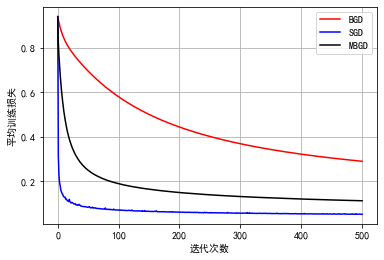

In [8]:
#解决中文乱码问题
mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False

col = ['BGD','SGD','MBGD']
x = np.arange(len(BGD_Cost))
plt.plot(x,BGD_Cost,'r-')
plt.plot(x,SGD_Cost,'b-')
plt.plot(x,MBGD_Cost,'k-')
plt.grid(True)
plt.legend(labels=col,loc='best')
plt.xlabel('迭代次数')
plt.ylabel('平均训练损失')
plt.show()
plt.close()

用训练好的模型对测试数据集进行分类

In [9]:
BGD_predict = LR_BGD.predict(Test_Data)
SGD_predict = LR_SGD.predict(Test_Data)
MBGD_predict = LR_MBGD.predict(Test_Data)

评估模型：
1.精度
2.查准率
3.召回率
4.f1度量
5.混淆矩阵

In [10]:
#自定义函数
def Merge(data,row,col):
    """
    生成DataFrame数据的函数
    :param data:数据，格式为列表
    :param row:行名称
    :param row:列名称
    """
    data = np.array(data).T
    return pd.DataFrame(data=data,columns=col,index=row)

def Confusion_Matrix_Merge(confusion_matrix,name):
    return pd.DataFrame(data=confusion_matrix,index=name,columns=name)

In [11]:
#计算精度
BGD_accuracy = accuracy_score(Test_Label,BGD_predict)
SGD_accuracy = accuracy_score(Test_Label,SGD_predict)
MBGD_accuracy = accuracy_score(Test_Label,MBGD_predict)
accuracy = [BGD_accuracy,SGD_accuracy,MBGD_accuracy]
print("BGD算法的精度：",BGD_accuracy)
print("SGD算法的精度：",SGD_accuracy)
print("MBGD算法的精度：",MBGD_accuracy)

BGD算法的精度： 0.9300699300699301
SGD算法的精度： 0.965034965034965
MBGD算法的精度： 0.9790209790209791


In [12]:
#计算查准率
BGD_precision = precision_score(Test_Label,BGD_predict)
SGD_precision = precision_score(Test_Label,SGD_predict)
MBGD_precision = precision_score(Test_Label,MBGD_predict)
precision = [BGD_precision,SGD_precision,MBGD_precision]
print("BGD算法的查准率：",BGD_precision)
print("SGD算法的查准率：",SGD_precision)
print("MBGD算法的查准率：",MBGD_precision)

BGD算法的查准率： 0.9175257731958762
SGD算法的查准率： 0.9777777777777777
MBGD算法的查准率： 0.9888888888888889


In [13]:
#计算召回率
BGD_recall = recall_score(Test_Label,BGD_predict)
SGD_recall = recall_score(Test_Label,SGD_predict)
MBGD_recall = recall_score(Test_Label,MBGD_predict)
recall = [BGD_recall,SGD_recall,MBGD_recall]
print("BGD算法的召回率：",BGD_recall)
print("SGD算法的召回率：",SGD_recall)
print("MBGD算法的召回率：",MBGD_recall)

BGD算法的召回率： 0.978021978021978
SGD算法的召回率： 0.967032967032967
MBGD算法的召回率： 0.978021978021978


In [14]:
#计算f1度量
BGD_f1 = f1_score(Test_Label,BGD_predict)
SGD_f1 = f1_score(Test_Label,SGD_predict)
MBGD_f1 = f1_score(Test_Label,MBGD_predict)
f1 = [BGD_f1,SGD_f1,MBGD_f1]
print("BGD算法的f1:",BGD_f1)
print("SGD算法的f1:",SGD_f1)
print("MBGD算法的f1:",MBGD_f1)

BGD算法的f1: 0.9468085106382979
SGD算法的f1: 0.9723756906077348
MBGD算法的f1: 0.9834254143646408


In [15]:
#计算混淆矩阵
BGD_confusion_matrix = confusion_matrix(Test_Label,BGD_predict)
SGD_confusion_matrix = confusion_matrix(Test_Label,SGD_predict)
MBGD_confusion_matrix = confusion_matrix(Test_Label,MBGD_predict)
print("BGD算法的混淆矩阵：",BGD_confusion_matrix)
print("SGD算法的混淆矩阵：",SGD_confusion_matrix)
print("MBGD算法的混淆矩阵：",MBGD_confusion_matrix)

BGD算法的混淆矩阵： [[44  8]
 [ 2 89]]
SGD算法的混淆矩阵： [[50  2]
 [ 3 88]]
MBGD算法的混淆矩阵： [[51  1]
 [ 2 89]]


In [16]:
#合并分类性能指标
col = ["精度","查准率","召回率","f1"]
row = ["BGD","SGD","MBGD"]
Result = [accuracy,precision,recall,f1]
Result = Merge(Result,row,col)
Result.to_csv("./3中算法的分类性能指标.csv")

In [17]:
#保存混淆矩阵
#首先构建一个Excel写入类的实例
writer = pd.ExcelWriter("./混淆矩阵.xlsx")
#之后把BGD、SGD、和MBGD算法下的混淆矩阵转化为DataFrame
BGD_confusion_matrix = Confusion_Matrix_Merge(BGD_confusion_matrix,['正例','反例'])
SGD_confusion_matrix = Confusion_Matrix_Merge(SGD_confusion_matrix,['正例','反例'])
MBGD_confusion_matrix = Confusion_Matrix_Merge(MBGD_confusion_matrix,['正例','反例'])
#依次把DataFrame以sheet的形式写入Excel
BGD_confusion_matrix.to_excel(writer,sheet_name='BGD')
SGD_confusion_matrix.to_excel(writer,sheet_name='SGD')
MBGD_confusion_matrix.to_excel(writer,sheet_name='MBGD')
writer.save()

综合考虑各项性能指标，MBGD算法在训练集和测试集上表现得更出色，下面研究不同的学习率和不同的小批量样本规模对算法的影响

寻求最佳学习率

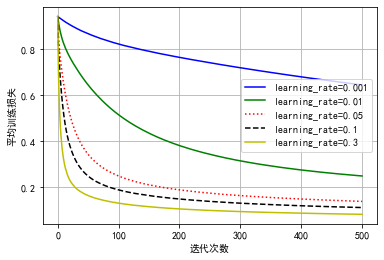

In [18]:
learning_rates = [0.001,0.01,0.05,0.1,0.3]
choices = ["b-","g-","r:","k--","y-"]
label = []
accuracy = []
precision = []
recall = []
f1 = []
#遍历每个学习率，获取该学习率下Logistic回归模型的评价训练损失
for learning_rate,choice in zip(learning_rates,choices):
    #生成每组结果的图例标签
    label.append("learning_rate="+str(learning_rate))
    #构造MBGD优化算法的Logistic模型
    LR_MBGD = LogisticRegression(Train_Data,Train_Label,Theta)
    #利用MBGD算法训练Logistic回归模型，并返回平均训练损失
    MBGD_Cost = LR_MBGD.train_MBGD(iteration,batch_size,learning_rate)
    #绘制迭代次数与平均训练损失曲线
    plt.plot(np.arange(len(MBGD_Cost)),MBGD_Cost,choice)
    #利用Logistic回归模型对测试数据集进行预测
    Test_predict = LR_MBGD.predict(Test_Data)
    #计算精度、查准率、召回率和f1分类性能指标
    accuracy.append(accuracy_score(Test_Label,Test_predict))
    f1.append(f1_score(Test_Label,Test_predict))
    precision.append(precision_score(Test_Label,Test_predict))
    recall.append(recall_score(Test_Label,Test_predict))
#合并分类性能指标结果
Data = [accuracy,precision,recall,f1]
Data = Merge(Data,label,col)
#保存为excel表
Data.to_excel("./不同学习率下MBGD的评价指标.xlsx")

#结果可视化
plt.xlabel("迭代次数")
plt.ylabel("平均训练损失")
plt.grid(True)
plt.legend(labels=label,loc='best')
plt.show()
plt.close()

寻求最佳小批量样本规模

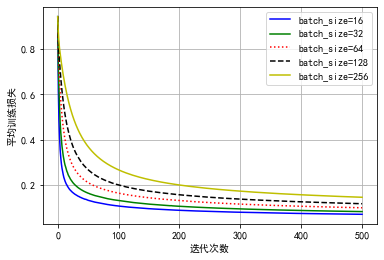

In [21]:
batch_sizes = [16,32,64,128,256]
choices = ['b-','g-','r:','k--','y-']
label = []
accuracy = []
precision = []
recall = []
f1 = []
#遍历每个学习率，获取该学习率下的平均训练损失
for batch_size,choice in zip(batch_sizes,choices):
    label.append('batch_size='+str(batch_size))
    #构造MBGD算法训练Logistic回归模型
    LR_MBGD = LogisticRegression(Train_Data,Train_Label,Theta)
    #利用MBGD算法训练Logistic回归模型，并返回平均训练损失
    MBGD_Cost = LR_MBGD.train_MBGD(iteration,batch_size,learning_rate)
    plt.plot(np.arange(len(MBGD_Cost)),MBGD_Cost,choice)
    #利用Logistic回归模型对测试数据集进行预测
    Test_predict = LR_MBGD.predict(Test_Data)
    #计算精度、查准率、召回率、f1
    accuracy.append(accuracy_score(Test_Label,Test_predict))
    precision.append(precision_score(Test_Label,Test_predict))
    recall.append(recall_score(Test_Label,Test_predict))
    f1.append(f1_score(Test_Label,Test_predict))
#合并分类性能指标结果
Data = [accuracy,precision,recall,f1]
Data = Merge(Data,label,col)
Data.to_excel('./不同小批量样本规模下MBGD的评价指标.xlsx')
plt.xlabel('迭代次数')
plt.ylabel('平均训练损失')
plt.grid(True)
plt.legend(labels=label,loc='best')
plt.show()
plt.close()